## Deep learning demystified: HIV protease substrate prediction

Last time we looked into random forest for classification of COVID19 patients and figure out that machine learning can be used for not only classification but also for scoring features between two classes (feature importance).

Today, we will have a look at how to translate a general question into something we can solve with machine learning/deep learning.
Specifically, we will try to predict substrates of a viral protease (HIV).

For this task we will use the data from [this paper](https://academic.oup.com/bioinformatics/article/31/8/1204/212810) which can be found at the UCI machine learning repository [here](https://archive.ics.uci.edu/ml/datasets/HIV-1+protease+cleavage).

There are 4 datasets and we will use 3 together for training the model and 1 for testing performance at the end after selecting our favourite model.

Each dataset has a series of peptides with fixed lenght of 8 and a label depending whether is cleaved by the HIV protease (1) or not (-1).

As before we will follow the steps outlined in the previous series of post.

- 1. Merge all available data into a single dataframe
- 2. Convert all features to number
- 3. Train a model and calculate performance
- 4. Parameter tuneup
- 5. Prediction

**So let's start coding!**



In [1]:
import pandas as pd
import numpy as np

data1 = pd.read_csv('746Data.txt', sep=",", header=None)
data2 = pd.read_csv('1625Data.txt', sep=",", header=None)
data3 = pd.read_csv('impensData.txt', sep=",", header=None)
test_data = pd.read_csv('schillingData.txt', sep=",", header=None)

# merge all data in single dataframe
tots = pd.concat([data1, data2, data3])
tots.head(5)

,0,1
0,AAAKFERQ,-1
1,AAAMKRHG,-1
2,AAAMSSAI,-1
3,AAKFERQH,-1
4,AAKFESNF,-1


### Feature encoding

Differently from our previous example, now we have a sequence of letters. No algorithm will work with that, so we need to convert it to numbers. There are several ways for doing so, but the easiest one is to define manually all aminoacids and give them arbitrary integers, we will end up with a dataframe where every aminoacid is _encoded_ by  a number

In [2]:
def preprocess_seq(df, aa):
    """
    receive a two column df with df[0] is a peptide and df[1] is class label
    returns encoded features as integer and labels
    """
    char_dict = {}
    for index, val in enumerate(aa):
        char_dict[val] = index+1

    # now that we have a dictionary we can just split the sequence in multiple column
    sequences = df[0].str.split('', expand=True)

    # and replace every letter with a number
    for colname in list(sequences):
        sequences[colname] = sequences[colname].str.upper().map(char_dict)
    
    # there are empty columns, we are just going to drop them
    sequences.dropna(axis=1, inplace=True)
    return sequences.values, df[1].values


aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# get features and labels
X, y = preprocess_seq(tots, aa)

X_test, y_test = preprocess_seq(test_data, aa)



### Keep it simple (at first)!

Okay now that we took care of having *only* numerical features we are going to give it a shot with some traditional machine learning.
**Before trying to use complicated and hard to train deep learning model is advisable to try simpler ML models such as random forest or SVM and see if the problem can be solved in this way**

As before we will use the random forest algorithm and use [k-fold cross validation](https://scikit-learn.org/stable/modules/cross_validation.html) to evaluate performance.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix



# as before random forest is usually my to go as first trial
clf_rf = RandomForestClassifier(random_state=42)

# 5 fold cv
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# we will save results of performance on every fold here
perf =[]

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf=clf_rf.fit(X_train,y_train)
    y_pred = clf_rf.predict(X_test)
    perf.append(confusion_matrix(y_test, y_pred).ravel())

### Confusion matrix and more performance metrics

The 2d array perf is a confusion matrix which contains the number of true positive, false positive, false negative and true negative based on our classifier and the ground label. From this we can calculate all [performance metrics](https://en.wikipedia.org/wiki/Precision_and_recall) which is why I usually just extract the confusion matrix and calculate metrics by hand.
Let's not forget that cross validation works on the *training data* so it is a measure of performance but not generalization!

In [4]:
perf_df = pd.DataFrame(perf, columns=['tn', 'fp', 'fn', 'tp'])
tn,fp,fn,tp = perf_df.values[:,0], perf_df.values[:,1], perf_df.values[:,2], perf_df.values[:,3]    
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp+tn) / (tp+fp+tn+fn)
f1 = 2 * ((precision*recall) / (precision+recall))
mcc = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

metr = pd.DataFrame({
                     'rec': recall,
                     'prec': precision,
                     'acc': accuracy,
                     'f1': f1,
                     'mcc':mcc,
                    })
# average performance across fold
metr = pd.DataFrame(metr.mean()).T
metr['clf'] = 'rf'
metr

,rec,prec,acc,f1,mcc,clf
0,0.807404,0.940215,0.932192,0.868633,0.827755,rf


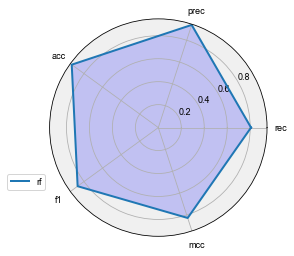

In [5]:
import matplotlib.pyplot as plt
import math as m

def radarplot(df, nm):
    font = {'size': 9}
    plt.rc('font', **font)
    plt.rcParams["font.family"] = "arial"
    categories = list(df)[:-1]
    N = len(categories)
    values = df.loc[0].drop('clf').values.flatten().tolist()
    values += values[:1]
    angles = [n / float(N) * 2 * m.pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(111, polar=True)
    ax.set_facecolor('#F0F0F0')

    plt.xticks(angles[:-1], categories, color='black', size=9)

    ax.set_rlabel_position(30)
    # min and max [0.72, 1], middle circle is 0.86
    #plt.yticks([0.72, 0.86, 1], ["0.72", "0.86", "1.0"], color="black", size=9)
    # plt.ylim(0.72,1)

    for idx, nm in enumerate(nm):
        values = df.loc[idx].drop('clf').values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=nm)
        ax.fill(angles, values, 'b', alpha=0.1)

  
    # Add legend
    plt.legend(loc='right', bbox_to_anchor=(0, 0.25), fontsize=9)


    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.savefig('./legend.pdf', dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()
    
    
radarplot(metr, nm=list(metr['clf']))


Pretty good! Similar to the [previous](https://anfoss.github.io/posts/2020/08/covidpred2/) example the classes are unbalanced. So accuracy and precision, which are *unbalanced* metric are *really good* while *balanced metric* such as MCC, F1 are *okayish*. Interestingly, recall is lower than precision so this suggests that we are not doing a good job in *separating ground truth positive from the rest while we do a good job in predicting negative samples*. 

## Deep learning here we come!

DISCLAIMER: This is not gonna be a full on deep learning explanation, but rather a small description of how neural nets are working and what's going on under the hood when we train a deep learning model. As before I will explain things as I go but will give a bit of background here.

**Neural networks are function approximators**, meaning that given a set of points in a N-dimensional feature space and a set of labels, the neural net tries to separate the labels by learning a non-linear function.

Networks architectures are build on three things:

- Neurons which pass information by *receiving an input and produce a single output*
- Weights which represent the *connection between neurons* and the 'significance' of a connection
- Propagation which tells to the network *how* to move information

Here is an example of a basic network with 3 input neurons (which means the input dataset needs to have 3 columns), 4 neurons in the hidden layer and 2 output neurons (which means this network can predict up to 3 classes).

Each output neuron returns one value which can be read as *per class probability*.

At the beginning of the training procedure, each neuron in one layer is connected to all neurons in the next layer but, during training, the connections *weights* gets modified.


These weights change based on a function (*loss function*) calculated at the end of every cycle of training (or *epoch*). This function is usually *optimized*, meaning that there is a gradient which tells us how to modify the weights.

*So in a nutshell the training procedure works that weights are initialized at random and then tuned on the dataset for a specific number of times (or epochs)*. To speed-up computation the data is usually splitted into *mini batches*.

**But no fear**! Everything is automatic and all libraries are user-friendly.
In Python there are several libraries for deep learning but for beginner I recommend [Keras](https://keras.io) and then move to [TensorFlow](https://www.tensorflow.org) when specific architecture are needed.



In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input



# building a neural network with keras works like lego.
# first we initialize an empty model
model = Sequential()
# then we add one layer with 100 neurons
model.add(Dense(units = 100, input_dim=X.shape[1], activation = 'tanh', name='hidden1'))
# another hidden layer with 100 neurons
model.add(Dense(units = 100, activation = 'relu', name='hidden2'))

# we want to predict positive/negative. So we use 1 output neuron which outputs the probability of positive/negative
model.add(Dense(units = 1, activation = 'sigmoid', name='output'))
# we define the optimizer to use and the learning rate (lr)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['acc'], lr=0.001)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               900       
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 11,101
Trainable params: 11,101
Non-trainable params: 0
_________________________________________________________________


And our model is ready to roll! So to recapitulate,

- We defined how many columns or input neurons we have in the data (**input_dim=X.shape[1]** in hidden1)
- We added 2 hidden layers with 100 neurons 
- We have one output neuron which returns the probability of a peptide being cleaved or not cleaved by HIV protease

On the contrary of traditional machine learning where we can use cross validation for evaluating performance, in deep learning is better to train on a large set of samples, but also we need a independent test (*validation set*) to keep track of performance at every epoch (cycle of training).

For this we will split the data further in validation and training using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [7]:
from sklearn.model_selection import train_test_split

# replace -1 with 0 for prediction
y[y == -1] = 0
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)


# we fit the model similar to sklearn but using 100 epochs (aka training cycle) 
# we split the dataset in 256 parts (mini-batches)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=256, 
                    # set verbose = 1 to have full output
                    verbose=0
                    )

In [30]:
np.savetxt("X_train.csv", X_train, delimiter=",")
np.savetxt("X_val.csv", X_val, delimiter=",")
np.savetxt("y_train.csv", y_train, delimiter=",")
np.savetxt("y_val.csv", y_val, delimiter=",")
np.savetxt("X_test.csv", X_test, delimiter=",")
np.savetxt("y_test.csv", y_test, delimiter=",")

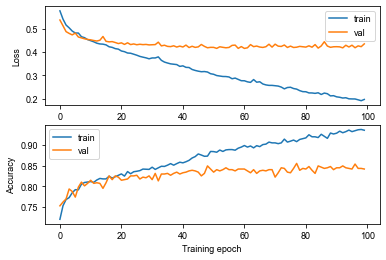

Accuracy: 0.800733
Precision: 0.167683
Recall: 0.126728
F1 score: 0.144357
ROC AUC: 0.566332


In [9]:
# we can add a function to plot accuracy and loss per epoch
import matplotlib.pyplot as plt

# we also can calculate some performance metrics to compare with rf
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


def qc_plots(model, history, X_train, y_train, X_test, y_test, pre='100units2hidden'):
    plt.subplot(211)
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.subplot(212)
    plt.ylabel('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='val')
    plt.xlabel('Training epoch')
    plt.legend()
    plt.savefig('{}_training.pdf'.format(pre), bbox_inches='tight', dpi=1600)
    plt.show()

    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)

    yhat_probs = model.predict(X_test, verbose=0)
    yhat_classes = model.predict_classes(X_test, verbose=0)
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]

    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % accuracy)
    precision = precision_score(y_test, yhat_classes)
    print('Precision: %f' % precision)
    recall = recall_score(y_test, yhat_classes)
    print('Recall: %f' % recall)
    f1 = f1_score(y_test, yhat_classes)
    print('F1 score: %f' % f1)
    auc = roc_auc_score(y_test, yhat_probs)
    print('ROC AUC: %f' % auc)
    

def metrics(model, X_test, y_test):
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    yhat_probs = model.predict(X_test, verbose=0)
    yhat_classes = model.predict_classes(X_test, verbose=0)
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]

    accuracy = accuracy_score(y_test, yhat_classes)
    precision = precision_score(y_test, yhat_classes)
    recall = recall_score(y_test, yhat_classes)
    f1 = f1_score(y_test, yhat_classes)
    auc = roc_auc_score(y_test, yhat_probs)
    return ['base dnn', accuracy, precision, recall, f1, auc] 

# regenerate test data
X_test, y_test = preprocess_seq(test_data, aa)
y_test[y_test == -1] = 0
qc_plots(model, history, X_train, y_train, X_test, y_test)

**Ouch!** Our wonderful model is performing well on the training data but bad on the test data! This is another example of [overfitting](https://en.wikipedia.org/wiki/Overfitting) the training data. It can be seen from the loss function as it *increase* in the validation set at every epoch (training cycle) while it should be decreasing and overlap with the validation set.


*Basically our network is remembering examples from the training data rather than really learning the general relationship between features and labels (cleaved by HIV protease or not cleaved)*.


In the next post we will try to fix this and actually achieve a almost perfect classification by making the model forget during training! Yep you heard correctly, our network will perform better by forgetting things it learns.